<a href="https://colab.research.google.com/github/mbburabak/Tutorials/blob/master/Graphsage%20proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install stellargraph

In [44]:
from stellargraph import StellarGraph
import networkx as nx
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from keras.models import load_model

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Loading df
filename = 'df.pkl'
df = pickle.load(open(filename, 'rb'))

In [0]:
edgelist = df[['prev_order','res_id']]
#Dropping first orders
edgelist = edgelist[edgelist['prev_order'] != 0]
edgelist.rename(columns = {'prev_order':'source','res_id':'target'}, inplace = True)

In [0]:
x = edgelist['target'].unique()
y = edgelist[~edgelist['source'].isin(x)]['source'].unique()
list_node = np.append(x,y)

In [0]:
df['dummy_for_cuisine_id'] = 1
cuisine_pivot = pd.pivot_table(df,index = 'res_id',columns ='cuisine_id',values = 'dummy_for_cuisine_id').fillna(0)
cuisine_pivot = cuisine_pivot[cuisine_pivot.index.isin(list_node)]

In [13]:
G = StellarGraph({"restaurant": cuisine_pivot}, {"net_order": edgelist})
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 4875, Edges: 827852

 Node types:
  restaurant: [4875]
    Features: float32 vector, length 23
    Edge types: restaurant-net_order->restaurant

 Edge types:
    restaurant-net_order->restaurant: [827852]
        Weights: all 1 (default)


In [0]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

In [0]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

In [0]:
batch_size = 20
epochs = 20
num_samples = [20, 10]

In [0]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [0]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [0]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [0]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

In [21]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [0]:
 model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [25]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
7451/7451 - 1279s - loss: 0.5636 - acc: 0.7126 - val_loss: 0.6043 - val_acc: 0.6299
Epoch 2/20
7451/7451 - 1276s - loss: 0.5404 - acc: 0.7327 - val_loss: 0.4900 - val_acc: 0.7418
Epoch 3/20
7451/7451 - 1273s - loss: 0.5280 - acc: 0.7447 - val_loss: 0.6511 - val_acc: 0.5812
Epoch 4/20
7451/7451 - 1293s - loss: 0.5254 - acc: 0.7402 - val_loss: 0.6282 - val_acc: 0.6102
Epoch 5/20
7451/7451 - 1285s - loss: 0.5198 - acc: 0.7522 - val_loss: 0.4708 - val_acc: 0.7546
Epoch 6/20
7451/7451 - 1285s - loss: 0.5036 - acc: 0.7632 - val_loss: 0.4591 - val_acc: 0.7665
Epoch 7/20
7451/7451 - 1284s - loss: 0.5030 - acc: 0.7546 - val_loss: 0.4568 - val_acc: 0.7684
Epoch 8/20
7451/7451 - 1309s - loss: 0.4985 - acc: 0.7653 - val_loss: 0.4619 - val_acc: 0.7730
Epoch 9/20
7451/7451 - 1353s - loss: 0.4930 - acc: 0.7726 - val_loss: 0.4601 - val_acc: 0.7693
Epoch 10/20
7451/7451 - 1345s - loss: 0.4925 - acc: 0.7738 - val_loss: 0.4555 - val_acc: 0.7822
Epoch 11/20
7451/7451 - 1340s - loss: 0.4969 - ac

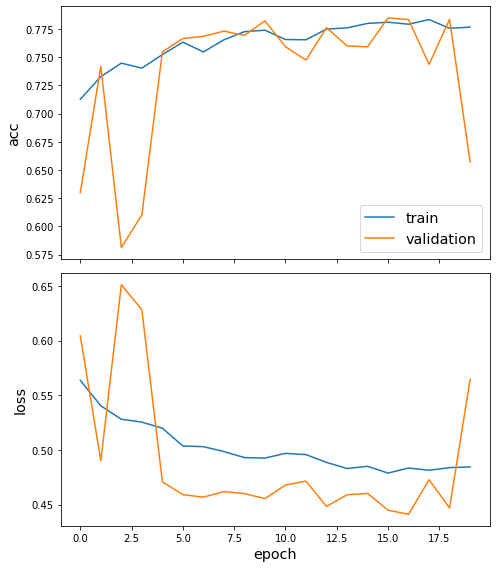

In [26]:
sg.utils.plot_history(history)

In [27]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

8279/8279 [==============================] - 736s 89ms/step - loss: 0.5645 - acc: 0.6566

Train Set Metrics of the trained model:
	loss: 0.5615
	acc: 0.6607

Test Set Metrics of the trained model:
	loss: 0.5645
	acc: 0.6566


In [0]:
def get_recommended_restaurants(user):
  test_data = df[df['client'] == user]
  test_edgelist = test_data[['prev_order','res_id']]
  test_edgelist = test_edgelist[test_edgelist['prev_order'] != 0]
  test_edgelist.rename(columns = {'prev_order':'source','res_id':'target'}, inplace = True)
  test_x = test_edgelist['target'].unique()
  test_y = test_edgelist[~test_edgelist['source'].isin(test_x)]['source'].unique()
  test_list_node = np.append(test_x,test_y)
  df['dummy_for_cuisine_id'] = 1
  test_cuisine_pivot = pd.pivot_table(df,index = 'res_id',columns ='cuisine_id',values = 'dummy_for_cuisine_id').fillna(0)
  test_cuisine_pivot = test_cuisine_pivot[test_cuisine_pivot.index.isin(test_list_node)]
  G_test1 = StellarGraph({"restaurant": test_cuisine_pivot}, {"net_order": test_edgelist})
  edge_splitter_test = EdgeSplitter(G_test1)
  test_G, edge_ids_test1, edge_labels_test1 = edge_splitter_test.train_test_split(p=0.99999, method="global", keep_connected=False)
  flow_test = train_gen.flow(edge_ids_test1, edge_labels_test1, shuffle=False)
  pred_list = []
  for i in model.predict(flow_test):
    pred_list.append(i[0])
  prediction = pd.DataFrame(list(zip(pred_list, edge_ids_test1[:,1])))
  prediction['probs'] = prediction.iloc[:,0]
  prediction['res_id'] = prediction.iloc[:,1]
  prediction = prediction[['res_id','probs']]
  #prediction = prediction.groupby('res_id').transform('mean')
  prediction = prediction.sort_values(by = 'probs',ascending = False).reset_index()
  prediction.drop(columns = 'index',axis = 1, inplace = True)
  prediction_rests = prediction['res_id'].unique()
  print(df[df['res_id'].isin(prediction_rests)]['restaurant_name'].unique())

In [214]:
get_recommended_restaurants('595ec31f1239b00004ef0375')

** Sampled 68 positive and 68 negative edges. **
['Pide Sepeti' 'Little Caesars (Dikilitaş Mah.)' 'Tost Mahal Burger'
 'Frango Döner & Sauce (Mecidiyeköy Mah.)'
 'Etiler Marmaris (Cihannüma Mah.)' 'Noodle House (Cihannüma Mah.)'
 'Fesleğen Cafe & Kahvaltı & Ev Yemekleri' 'House of B (Teşvikiye Mah.)'
 'Bakırda Kuru' 'Çiftlik Kasap Burger' 'Craft Ktchn' "Don Pablo's Grill"
 'Lahmacun Evi' 'Ay Kumpir' 'FitNgo' 'Neşe Mantı & Cafe'
 "Meat'ng Steakhouse & Burgers & Ribs" 'Otlangaç Kahvaltı & Cafe'
 'Limos Cafe & Kahvaltı'
 'Tane Kurufasulye & Kavurma & Pilav (Muradiye Mah.)' 'MRS Yaprak Tantuni'
 'Balık Kafası' 'Tostbusters (Gayrettepe Mah.)'
 'Mekan Kebap Pide & Lahmacun' 'By Ulus Steak House & Burger'
 'Uniq Kitchen Tost' 'Burger Z' 'Mrs Love Burger'
 'Boston Donuts (Mecidiyeköy Mah.)' "Deso's Restaurant" 'Betro Burger'
 'Coni & Co (Arnavutköy Mah.)' 'Meşhur Sarıyer Börekçisi (Emirhan Cad.)'
 'KFC (Beşiktaş)']


In [0]:
# model.fit süresi = 7 saat 20 dakika